# Comparing a USGSCSM and ISIS camera for Messenger MDIS NAC

In [ ]:
import os 

import pysis
from pysis import isis
from pysis.exceptions import ProcessError

import knoten
from knoten import vis

import json

import ale
from ale import util
from ale.drivers.mess_drivers import MessengerMdisPds3NaifSpiceDriver
from ale.formatters.usgscsm_formatter import to_usgscsm

from IPython.display import Image

import plotly
plotly.offline.init_notebook_mode(connected=True)

## Download Image

In [2]:
imageLink = 'https://pds-imaging.jpl.nasa.gov/data/messenger/MDIS/MDIS/MSGRMDS_1001/DATA/2015_114/EN1072174528M.IMG'
!wget -N -P data/ {imageLink}
fileName = 'data/' + os.path.split(imageLink)[1]


--2019-10-18 11:23:09--  https://pds-imaging.jpl.nasa.gov/data/messenger/MDIS/MDIS/MSGRMDS_1001/DATA/2015_114/EN1072174528M.IMG
Resolving pds-imaging.jpl.nasa.gov (pds-imaging.jpl.nasa.gov)... 128.149.114.60
Connecting to pds-imaging.jpl.nasa.gov (pds-imaging.jpl.nasa.gov)|128.149.114.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 269312 (263K) [application/octet-stream]
Server file no newer than local file ‘data/EN1072174528M.IMG’ -- not retrieving.



## Ingest the image and spiceinit

In [3]:
# Set the output location of the resulting .cub
cub_loc = os.path.splitext(fileName)[0] + '.cub'
json_loc = os.path.splitext(fileName)[0] + '.json'

try: 
    isis.mdis2isis(from_=fileName, to=cub_loc)
except ProcessError as e:
    print(e.stderr)

try:
    isis.spiceinit(from_=cub_loc, shape='ellipsoid')
except ProcessError as e:
    print(e.stderr)
    
kernels = ale.util.generate_kernels_from_cube(cub_loc, expand=True)
usgscsm_str = ale.loads(fileName, props={'kernels': kernels}, formatter="usgscsm", verbose=False)
csm_isd = os.path.splitext(fileName)[0] + '.json'
with open(csm_isd, 'w') as isd_file:
    isd_file.write(usgscsm_str)

## Compare USGS CSM and ISIS pixels

In [4]:
csmisis_diff_lv_plot, csmisis_diff_ephem_plot, external_orientation_data = vis.external_orientation_diff(csm_isd, cub_loc, 2, 2, 600, 600)

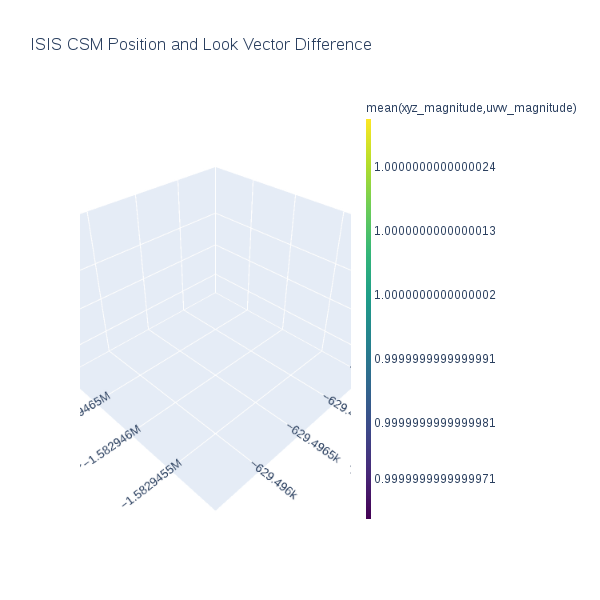

In [5]:
csmisis_diff_lv_plot_bytes = csmisis_diff_lv_plot.to_image(format="png")
csmisis_diff_ephem_plot_bytes = csmisis_diff_ephem_plot.to_image(format="png")
Image(csmisis_diff_lv_plot_bytes)

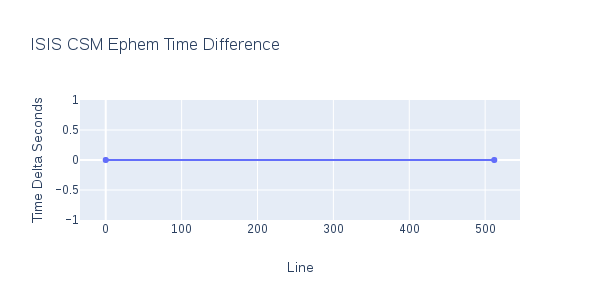

In [6]:
Image(csmisis_diff_ephem_plot_bytes)

In [7]:
external_orientation_data[['diffx', 'diffy', 'diffz', 'diffu', 'diffv', 'diffw']].describe()

,diffx,diffy,diffz,diffu,diffv,diffw
count,4.000000,4.00000,4.00000,4.000000e+00,4.000000e+00,4.000000e+00
mean,0.016048,-0.00657,-0.00014,6.491064e-03,3.675809e-05,-1.061184e-04
std,0.000000,0.00000,0.00000,7.495269e-03,4.251441e-05,1.225567e-04
min,0.016048,-0.00657,-0.00014,-1.203664e-12,6.695211e-11,-2.150628e-04
25%,0.016048,-0.00657,-0.00014,-1.181442e-12,6.770209e-11,-2.108238e-04
50%,0.016048,-0.00657,-0.00014,6.477289e-03,3.526579e-05,-1.047054e-04
75%,0.016048,-0.00657,-0.00014,1.296835e-02,7.202381e-05,6.095091e-11
max,0.016048,-0.00657,-0.00014,1.300968e-02,7.650073e-05,6.148282e-11


In [8]:
isis2csm_plot, csm2isis_plot, isiscsm_plotlatlon, isiscsm_plotbf, isis2csm_data, csm2isis_data, isiscsm_latlondata, isiscsm_bfdata = vis.reprojection_diff(csm_isd, cub_loc, 10, 10, 500, 500)

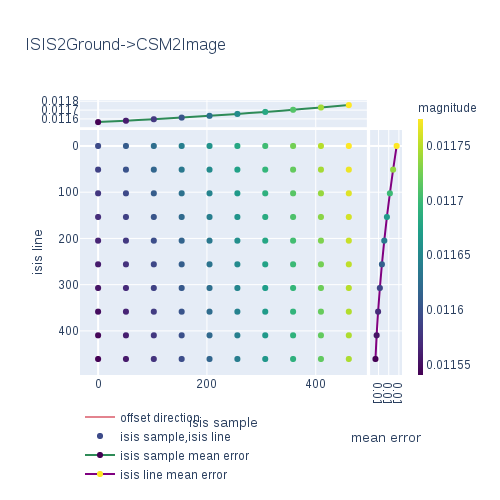

In [9]:
Image(isis2csm_plot.to_image())

In [10]:
isis2csm_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,100.000000,100.000000
mean,0.003437,0.011133
std,0.000095,0.000044
min,0.003261,0.011046
25%,0.003360,0.011099
50%,0.003434,0.011130
75%,0.003512,0.011166
max,0.003640,0.011236


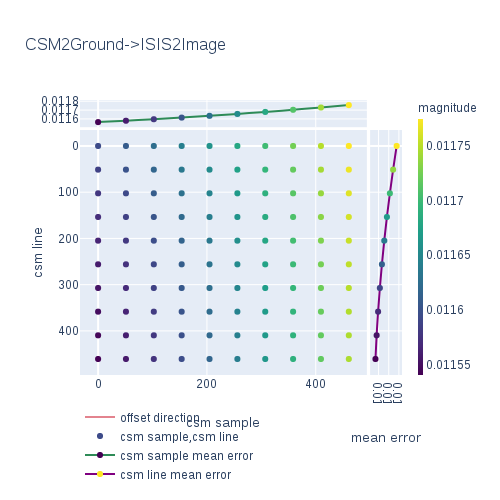

In [11]:
Image(csm2isis_plot.to_image())

In [12]:
csm2isis_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,100.000000,100.000000
mean,-0.003437,-0.011133
std,0.000095,0.000044
min,-0.003640,-0.011236
25%,-0.003512,-0.011166
50%,-0.003434,-0.011130
75%,-0.003360,-0.011099
max,-0.003261,-0.011046


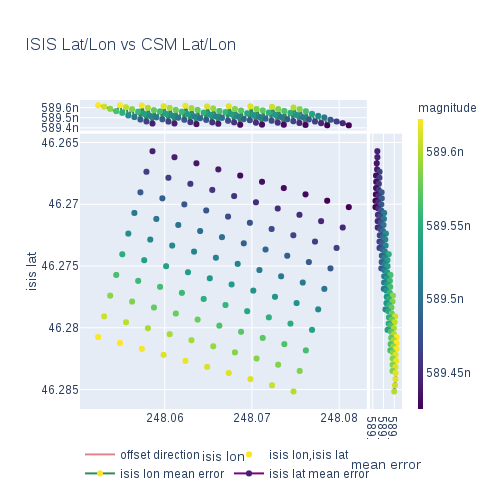

In [13]:
Image(isiscsm_plotlatlon.to_image())

In [14]:
isiscsm_latlondata[['diff lon', 'diff lat']].describe()

,diff lon,diff lat
count,1.000000e+02,1.000000e+02
mean,5.895103e-07,-3.871113e-09
std,5.833872e-11,4.175841e-11
min,5.894119e-07,-3.945168e-09
25%,5.894611e-07,-3.906401e-09
50%,5.895085e-07,-3.871158e-09
75%,5.895595e-07,-3.835854e-09
max,5.896102e-07,-3.798455e-09


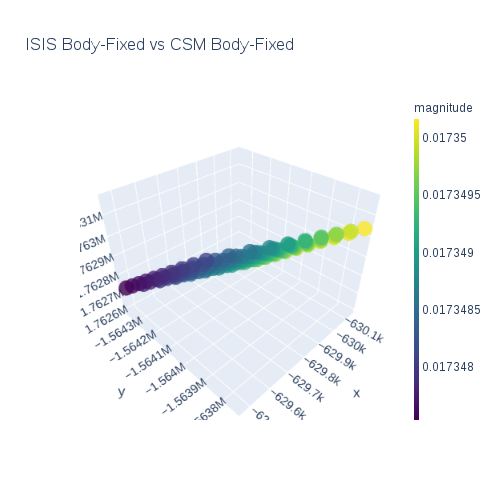

In [15]:
Image(isiscsm_plotbf.to_image())

In [16]:
isiscsm_bfdata[['diffx', 'diffy', 'diffz']].describe()

,diffx,diffy,diffz
count,100.000000,100.000000,100.000000
mean,0.017284,0.006590,0.000114
std,0.000190,0.000001,0.000001
min,0.016951,0.006588,0.000112
25%,0.017122,0.006589,0.000113
50%,0.017284,0.006590,0.000114
75%,0.017445,0.006591,0.000115
max,0.017625,0.006593,0.000116
